In [1]:
import uproot
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hist
import re

# Define a list of ROOT files to open
root_file_list = glob.glob('/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/*.root')

# Define a list of keys (TKeys) to extract data from
#efficiency not working properly, TEfficiency sucks
keys_to_extract = [["EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawValues", "ToT (LSB)"],
        ["ClusteringSpatial/RD50_MPW3_base_0/clusterSize", "Cluster size"],
        ["AnalysisDUT/RD50_MPW3_base_0/local_residuals/residualsX", r"Spatial Resolution X ($\mu m$)"]]

x_name = 'Bias (V)'
x_regex = r'(\d\d)V'
output_file = '/home/bernhard/privat/studium_physik/Diss/mpw3/testbeam/desy_2307/hv_vs_effi/characteristics.svg'

root_file_list




['/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/ana_hv_1325_70V.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/ana_hv_1327_50V.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/ana_hv_1331_10V.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/ana_hv_1328_40V.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/ana_hv_1324_80V.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/ana_hv_1329_30V.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/ana_hv_1323_90V.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/ana_hv_1330_20V.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/hv_scans/ana_hv_1326_60V.root']

In [2]:
# Create an empty DataFrame to store the results
# results_df = pd.DataFrame(columns=["File", "Key", "Mean", "StdDev"])
results = {"File" : [], "Key" : [], "Name" : [], "xVal" : [], "Mean" : [], "StdDev": [], "StdErr" : [], "N" :[] }

# Loop over each ROOT file
for root_file in root_file_list:
    # Open the ROOT file using uproot
    with uproot.open(root_file) as file:
        # Loop over each key to extract data
        for key_name in keys_to_extract:
            try:
                # Access the TKey using the key name
                tkey = file[key_name[0]]
                mean_val = 0
                std_dev_val = 0
                N = 0
                # Check if the TKey points to a TH1F histogram
                if isinstance(tkey, uproot.uproot.behaviors.TH1.TH1):                    
                    hist_np = tkey.to_numpy() # [0] ... bins, [1] ... weights
                    # hist_data = tkey.to_hist()
                    #hist_data.plot()
                    # plt.show()
                        
                    unjagged_bins = (hist_np[1][:-1] + hist_np[1][1:]) / 2
                    
                    N = np.sum(hist_np[0])
                    mean_val = np.sum(hist_np[0] * unjagged_bins) / N
                    #print('mean = ', mean_val)                    
                    std_dev_val = np.sqrt(np.sum(hist_np[0] * (unjagged_bins - mean_val)**2) / N)

                    #hacky special treatment
                    if 'hPixelRawValues' in key_name[0]:
                        mask = unjagged_bins < 100
                        N = np.sum(hist_np[0][mask])
                        mean_val = np.sum(hist_np[0][mask] * unjagged_bins[mask]) / N
                        std_dev_val = np.sqrt(np.sum(hist_np[0][mask] * (unjagged_bins[mask] - mean_val)**2) / N)
                    #print('std', std_dev_val)
                elif isinstance(tkey, uproot.uproot.behaviors.TProfile2D.TProfile2D):
                    # print('encountered a', tkey)
                    vals = tkey.values()
                    # print(vals, np.average(vals))
                    mean_val = np.average(vals)
                    std_dev_val = np.std(vals)
                    N = 1
                else:
                    continue

            
                results["xVal"].append(float(re.search(x_regex, root_file).group(1)))
                results["Mean"].append(mean_val)
                results['StdDev'].append(std_dev_val)
                results['File'].append(root_file)
                results['Key'].append(key_name[0])
                results['Name'].append(key_name[1])
                results["N"].append(N)
                results["StdErr"].append(std_dev_val / np.sqrt(N))

            except KeyError:
                print(f"Key '{key_name}' not found in file '{root_file}'")

df = pd.DataFrame(results)
df

,File,Key,Name,xVal,Mean,StdDev,StdErr,N
0,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawVa...,ToT (LSB),70.0,1.911534,1.378952,0.004904,79070.0
1,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,ClusteringSpatial/RD50_MPW3_base_0/clusterSize,Cluster size,70.0,1.058745,0.306651,0.001114,75734.0
2,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,AnalysisDUT/RD50_MPW3_base_0/local_residuals/r...,Spatial Resolution X ($\mu m$),70.0,0.182314,21.307095,0.108908,38276.0
3,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawVa...,ToT (LSB),50.0,1.753361,1.387900,0.004762,84934.0
4,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,ClusteringSpatial/RD50_MPW3_base_0/clusterSize,Cluster size,50.0,1.051461,0.282238,0.000984,82217.0
5,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,AnalysisDUT/RD50_MPW3_base_0/local_residuals/r...,Spatial Resolution X ($\mu m$),50.0,-0.447824,21.092463,0.100095,44405.0
6,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawVa...,ToT (LSB),10.0,1.668020,1.403808,0.011095,16010.0
7,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,ClusteringSpatial/RD50_MPW3_base_0/clusterSize,Cluster size,10.0,1.074532,0.311051,0.002530,15121.0
8,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,AnalysisDUT/RD50_MPW3_base_0/local_residuals/r...,Spatial Resolution X ($\mu m$),10.0,0.102205,22.143099,0.251464,7754.0
9,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawVa...,ToT (LSB),40.0,1.672941,1.498654,0.005577,72204.0


In [3]:
def annotate_points(df, col_name):
    for index, row in df.iterrows():
        if col_name != row['Key']:
            continue
        x = row['xVal']
        y = row['Mean']
        val = f'{row["Mean"]:.3f}'

        # hacky special treatment
        if 'residuals' in col_name:
            y = row['StdDev']
            val = f'{row["StdDev"]:.3f}'
        plt.annotate(val, (x, y), textcoords="offset points", xytext=(10, 15), ha='center', fontsize=8)

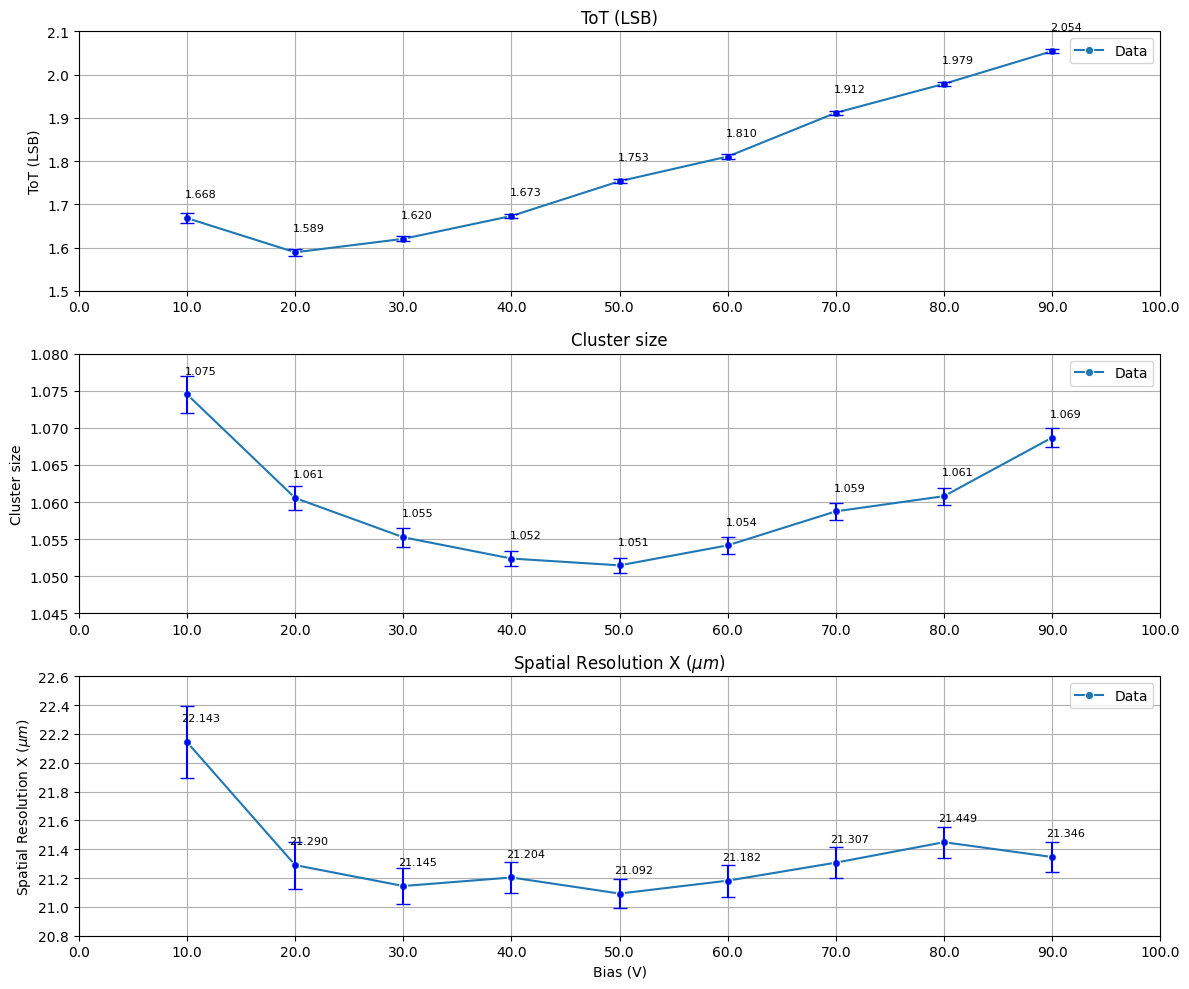

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your existing code for creating subplots
plt.figure(figsize=(12, 10))

for i, key in enumerate(keys_to_extract):
    keyrows = df[df['Key'].str.contains(key[0])]  # Get sub dataframe where all rows containing the current key are in
    plt.subplot(3, 1, i + 1)
    
    x = keyrows['xVal']
    y = keyrows['Mean']
    # hacky special treatment
    if 'residuals' in key[0]:
        y = keyrows['StdDev']
    
    yerr = df[df['Key'].str.contains(key[0])]['StdErr'].values
    
    # Plot a line plot with error bars
    sns.lineplot(x=x, y=y, label='Data', marker='o')
    plt.errorbar(x, y, yerr=yerr, fmt='.', color='blue', capsize=5)  # Add error bars
    
    plt.xlabel('')
    plt.ylabel(key[1])
    plt.title(key[1])
    annotate_points(df, key[0])

    # Add grid lines for both x-axis and y-axis in all subplots
    plt.grid(True, which='both')

    # Set y-ticks for all subplots
    plt.gca().set_yticks(plt.gca().get_yticks())

    ax = plt.gca()  # Get the current axis (last subplot)
    ax.set_xticks(ax.get_xticks())  # This line refreshes the tick locations
    ax.set_xticklabels(ax.get_xticks())  # Set tick labels to be the same as tick locations

plt.xlabel(x_name)
# Adjust layout
plt.tight_layout()

plt.savefig(output_file)
plt.show()
